In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from celluloid import Camera
from matplotlib import gridspec
from pathlib import Path

In [2]:
save_path = Path('save/rbm_relax')

sampler_names = {
    'gibbs': 'Block Gibbs',
    'hmc': 'R-HMC',
    'mala': 'R-MALA',
    'svgd': 'D-SVGD',
    'gwg': 'GWG'
}

seeds = np.arange(5)
dimensions = [25, 50, 100, 250, 500, 1000]

data = []
for seed in seeds:
    for d in dimensions:
        with open(save_path / 'random' / str(seed) / str(d) / 'results.pkl', 'rb') as f:
            results = pickle.load(f)
        samplers = list(results.keys())
        for sampler in ['hmc', 'mala']:
            variants = [v for v in samplers if v.startswith(sampler)]
            best_log_mmd = np.min([results[v][-1] for v in variants])
            data.append({
                'seed': seed,
                'dimension': d,
                'sampler_name': sampler_names[sampler],
                'log_mmd': best_log_mmd
            })
        for sampler in ['svgd', 'gwg', 'gibbs']:
            best_log_mmd = results[sampler][-1]
            data.append({
                'seed': seed,
                'dimension': d,
                'sampler_name': sampler_names[sampler],
                'log_mmd': best_log_mmd
            })

df = pd.DataFrame(data)
df = df.set_index(['sampler_name', 'seed', 'dimension'])

sampler_names_mnist = {
    'gibbs': 'Block Gibbs',
    'gwg': 'GWG',
    'svgd_1.0': 'D-SVGD',
    'mala-1.0-0.001': 'R-MALA',
    'hmc-1.0-0.001': 'R-HMC'
}

videos = {}
for sampler, sampler_name in sampler_names_mnist.items():
    samples = []
    for i in range(1000):
        sample = iio.imread(save_path / 'mnist' / str(0) / sampler.split('_')[0].split('-')[0] / f'samples_{sampler}_{10 * i}.png')
        samples.append(sample[-32:, :152, 0])
    videos[sampler_name] = samples

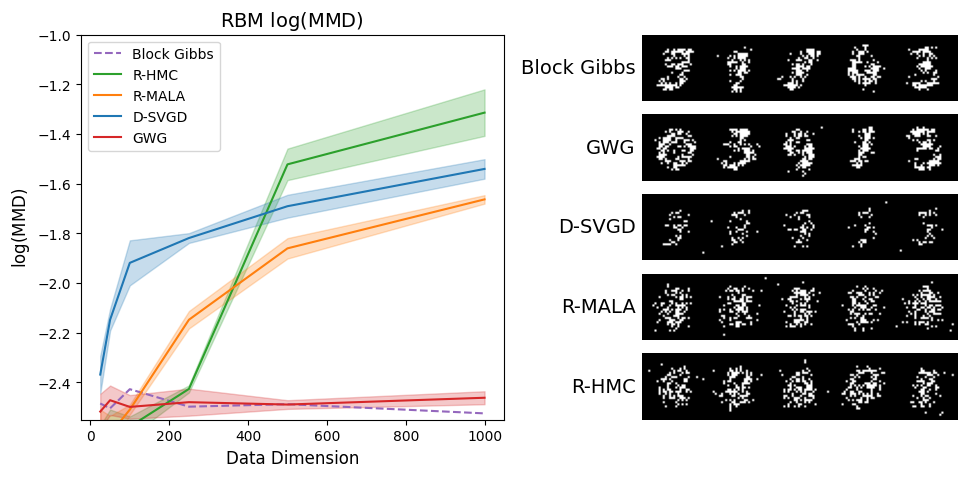

In [3]:
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(len(sampler_names), 2, width_ratios=[1, 1], wspace=0.2)
ax0 = fig.add_subplot(gs[:, 0])

colors = {
    'Block Gibbs': 'C4',
    'R-HMC': 'C2',
    'R-MALA': 'C1',
    'D-SVGD': 'C0',
    'GWG': 'C3',
}

for sampler in sampler_names.values():
    
    means = []
    sems = []

    for d in dimensions:
        log_mmd_vals = df.loc[(sampler, slice(None), d), 'log_mmd']
        means.append(log_mmd_vals.mean())
        sems.append(log_mmd_vals.std() / np.sqrt(len(log_mmd_vals)))

    means = np.array(means)
    sems = np.array(sems)

    color = colors[sampler]
    if sampler == 'Block Gibbs':
        ax0.plot(dimensions, means, linestyle='--', color=color, label=sampler)
    else:
        ax0.plot(dimensions, means, color=color, label=sampler)
        ax0.fill_between(dimensions, means - 1.96 * sems, means + 1.96 * sems, color=color, alpha=0.25)

    ax0.set_xlabel("Data Dimension", fontsize=12)
    ax0.set_ylabel(r"$\log(\mathrm{MMD})$", fontsize=12)
    ax0.set_ylim(-2.55, -1.0)
    ax0.set_title(r"RBM $\log(\mathrm{MMD})$", fontsize=14)
    ax0.legend(loc='upper left')

for i, (sampler_name, xs) in enumerate(videos.items()):

    ax_img = fig.add_subplot(gs[i, 1])
    ax_img.imshow(xs[-1], cmap='gray')
    ax_img.text(-0.02, 0.5, sampler_name, fontsize=14, va='center', ha='right', transform=ax_img.transAxes)
    ax_img.axis('off')

plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


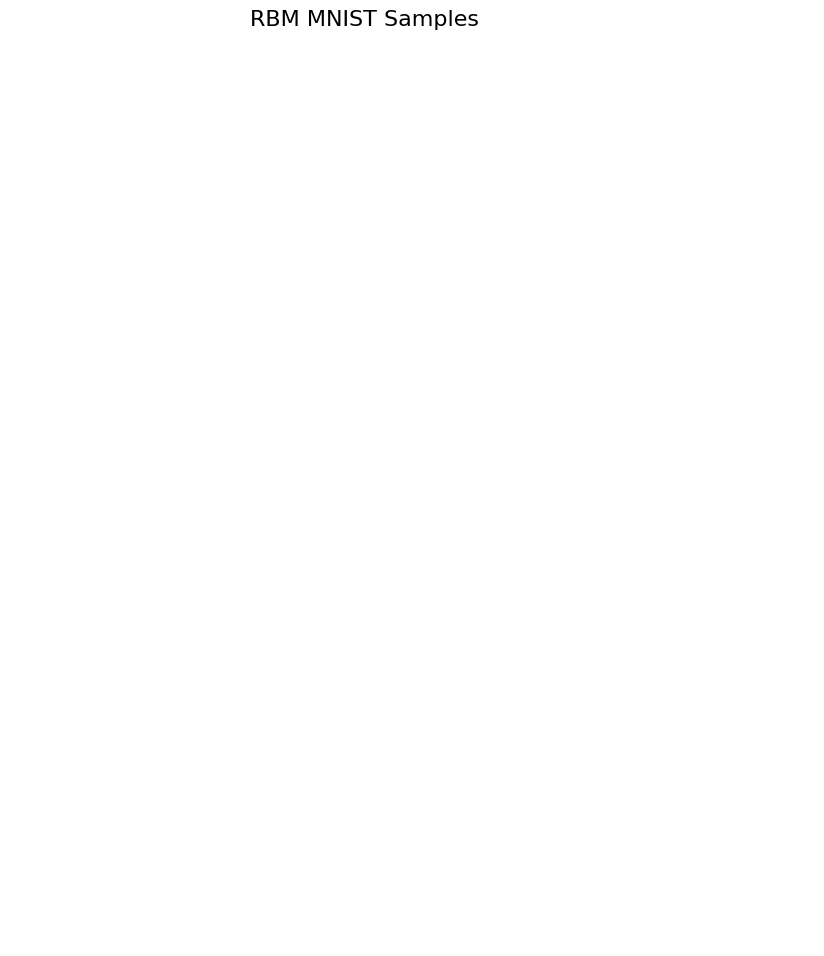

In [4]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(len(sampler_names), 1)

camera = Camera(fig)

for t in np.rint(np.linspace(1, np.sqrt(1000), 200) ** 2 - 1).astype(int):
    for i, (sampler_name, xs) in enumerate(videos.items()):
        ax_img = fig.add_subplot(gs[i, 0])
        ax_img.imshow(xs[t], cmap='gray')
        ax_img.text(-0.02, 0.5, sampler_name, fontsize=14, va='center', ha='right', transform=ax_img.transAxes)
        ax_img.axis('off')
    ax_img.text(0, -0.05, f'Iterations = {10 * t}', ha='left', va='top', fontsize=16, transform=ax_img.transAxes)
    fig.suptitle('RBM MNIST Samples', fontsize=16)
    plt.tight_layout()
    camera.snap()

animation = camera.animate()
animation.save(f'rbm_mnist_samples.gif', fps=10)